# VISUALIZING CAUSAL EFFECTS

In [0]:
import warnings
warnings.filterwarnings("ignore")

import torch.nn as nn
import math,joblib, copy
from torch.autograd import Variable
import torch

import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.plotly as py

import random, os, sys 
import datetime

### Architecture of the trained class-conditional-Beta-VAE network:

In [0]:
class BetaVAE_mnist_mod(nn.Module):
    
    def __init__(self, z_dim=10, nc=10):
        super(BetaVAE_mnist_mod, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Linear(794, 512),          
            nn.ReLU(True),
            nn.Linear(512, 256),          
            nn.ReLU(True),
            nn.Linear(256, 128),          
            nn.ReLU(True),                
            nn.Linear(128, z_dim*2),      
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim+10, 128),               
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),      
            nn.ReLU(True),
            nn.Linear(512, 784),
        )

    def _encode(self, x, y):
        return self.encoder(torch.cat([x, y], 1))

    def _decode(self, z, y):
        return self.decoder(torch.cat([z, y], 1))    
    
net=BetaVAE_mnist_mod
net = net(10,10)
checkpoint = torch.load(str(os.getcwd())+'/checkpoints/mnist_gamma100_z10/last')

pretrained_dict =checkpoint['model_states']['net']
model_dict = net.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict) 
net.load_state_dict(pretrained_dict)
print(net)

### ACE computation for class-specific neurons:

Enter no. of samples you want to use for z(encoded latent) and c(class-specific latent):<br>
Note: Monte Carlo methods perform better when sample size is large but you can see the effects even with <5 samples.

In [0]:
num_c=3 #no. of samples for class-specific latents
num_z=3 #no. of samples for encoded latents

Enter index of class neuron(0-9) whose ACE you want to see:

In [0]:
c=8 #class neuron whose ACE you want to see.

ACE computation:

In [0]:
decoder = net.decoder
ACEc=np.zeros((28, 28))
#ACEc[x][y] stores ACE by class neuron c on pixel at location (x,y)
start_time=datetime.datetime.now()

z=torch.randn(num_z,10)
label = torch.FloatTensor(np.zeros((1,10)))

label[0,c]=1

inp=torch.cat((z,label.expand([num_z,-1])),dim=-1)

sample=F.sigmoid(decoder(inp)).data
sample=sample.view(num_z,28,28)
ACEc=np.mean(sample.numpy(),axis=0)#This is just Interventional Expectation, Will later subtract Baseline

#For Baseline
prb=np.array([5923/60000.0,6742/60000.0,5958/60000.0,6131/60000.0,5842/60000.0,5421/60000.0,5918/60000.0,6265/60000.0,5851/60000.0,5949/60000.0])#probability of different class neurons
prb/=((1-prb[c])*1.0)#Updating probabilities after do(cth class neuron=0)
prb[c]=0

label=torch.FloatTensor(np.random.multinomial(1, prb, num_c))
zc_sum=np.zeros((28, 28))# In zc_sum[x][y] we store sum of outputs (inner expectation in baseline) at location (x,y) corresponding to different inputs got from different z's and c's.

for cx in range(0, num_c):
    inp=torch.cat((z,label[cx].expand([num_z,-1])),dim=-1)
    sample=F.sigmoid(decoder(inp)).data
    sample=sample.view(num_z,28,28)
    zc_sum+=np.sum(sample.numpy(),axis=0)
ACEc-=zc_sum/(num_z*num_c*1.0) #zc_sum/(num_z*num_c)[x][y] is baseline for ACE on pixel at location (x, y)
                    
end_time=datetime.datetime.now()        
print('ACE Computation done.')
print('Time taken= '+str(end_time-start_time))

ACE Computation done.
Time taken= 0:00:00.005488


### Generating Heat-Maps for class-specific neurons:

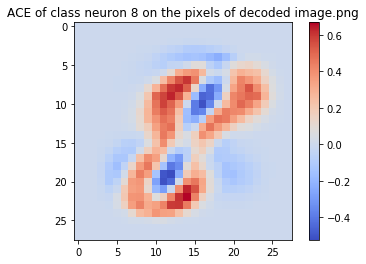

In [0]:
plt.imshow(ACEc, cmap='coolwarm', aspect='equal',interpolation='nearest')
plt.colorbar()
plt.title("ACE of class neuron "+str(c)+" on the pixels of decoded image.png")
plt.savefig("ACE of class neuron "+str(c)+" on the pixels of decoded image.png" , dpi=1000)
plt.show()

### ACE computation for encoded latent neurons:

Enter no. of samples you want to use for z(encoded latent):<br>
Note: Monte Carlo methods perform better when sample size is large but you can see the effects even with <5 samples.

In [0]:
num_z=2 #no. of samples for encoded latents

Enter index of encoded latent(0-9) whose ACE you want to see.<br>
Note: With our trained network, z0 was seen responsible for rotation and z6 for scaling. Other encoded latents were like nuisance.

In [0]:
zl=0 #encoded latent whose ACE you want to see.

Enter no. of interventions for which you want to compute ACE:

In [0]:
num_alpha=5 #no. of interventions for which you want to compute ACE
l=np.linspace(-3, 3, num_alpha)

Enter the index of class on whose decoded image you want to calculate ACE.

In [0]:
c=8#index of class on whose decoded image you want to calculate ACE.

In [0]:
decoder = net.decoder

start_time=datetime.datetime.now()

ACE=[]
for alpha in range(0, num_alpha):
    IEz=np.zeros((28, 28))#Interventional expectation for do(z=l[alpha])
    
    z=torch.randn(num_z,10)
    z[:,zl]=l[alpha]
    label = torch.FloatTensor(np.zeros((1,10)))

    label[0,c]=1

    inp=torch.cat((z,label.expand([num_z,-1])),dim=-1)

    sample=F.sigmoid(decoder(inp)).data
    sample=sample.view(num_z,28,28)
    
    IEz=np.mean(sample.numpy(), axis=0)
    
    ACE.append(IEz)
ACE=np.asarray(ACE)

ACE=ACE-np.mean(ACE, axis=0)#np.mean(ACE, axis=0) is baseline obtained by averaging over interventional expectations for different interventions.

end_time=datetime.datetime.now()        
print('ACE Computation done.')
print('Time taken= '+str(end_time-start_time))   

ACE Computation done.
Time taken= 0:00:00.014386


### Generating Heat-Maps for encoded latent neurons:

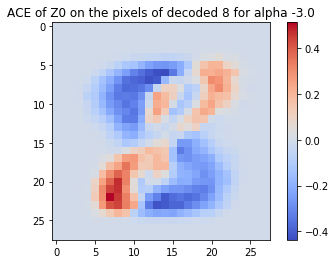

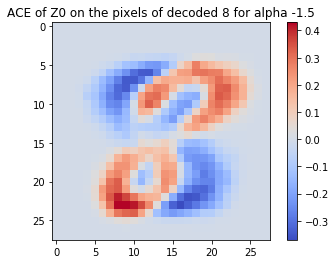

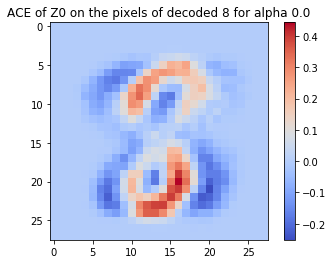

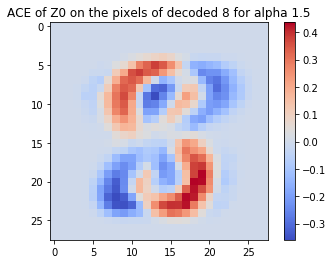

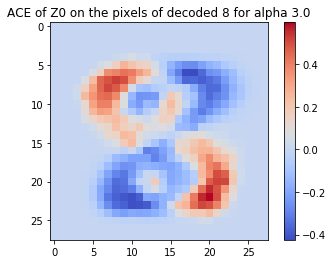

In [0]:
for i in range(0, num_alpha):
    plt.imshow(ACE[i], cmap='coolwarm', aspect='equal',interpolation='nearest')
    plt.colorbar()
    plt.title("ACE of Z"+str(zl)+" on the pixels of decoded "+str(c)+" for alpha "+str(l[i]))
    plt.savefig("ACE of Z"+str(zl)+" on the pixels of decoded "+str(c)+" for alpha "+str(l[i])+".png", dpi=1000)
    plt.show()

### Effects of encoded latents:

gif showing effect of different encoded latents for different values of intervention:

In [0]:
with open('random_z.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

Visualize decoded images on intervening given encoded latent:<br>
Enter index of encoded latent(0-9) whose effect you want to see.<br>
Note: With our trained network, z0 was seen responsible for rotation and z6 for scaling(For some initial values of intervention, z6 also caused rotation, as you can see in the above gif). Other latents were like nuisance.

In [0]:
zl=6

Enter the index of class on whose decoded image you want to see the effects.

In [0]:
c=8#index of class on whose decoded image you want to see the effects.
label=torch.FloatTensor(np.zeros(10))
label[c]=1#label is one-hot encoding with cth entry as 1

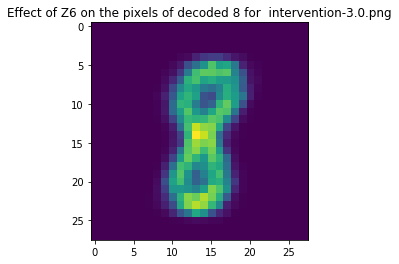

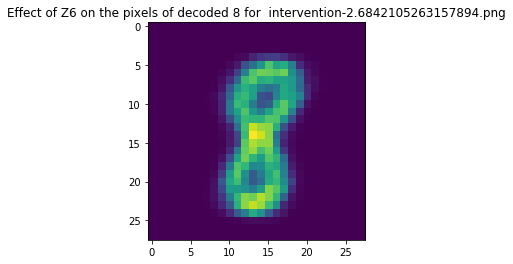

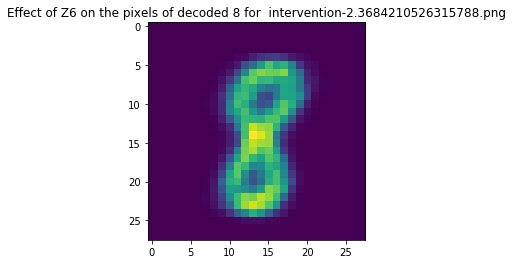

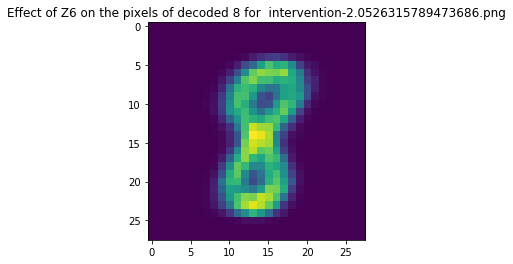

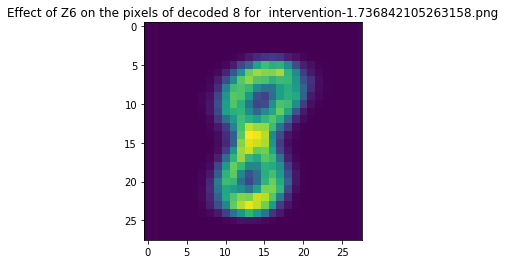

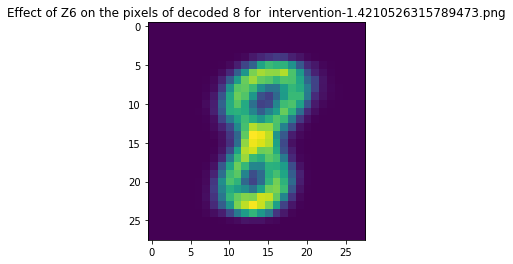

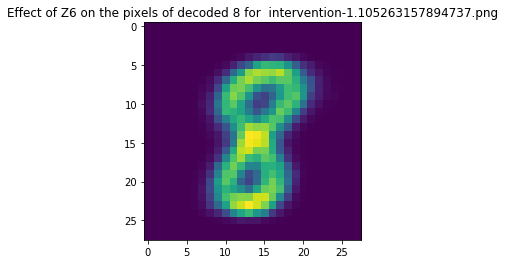

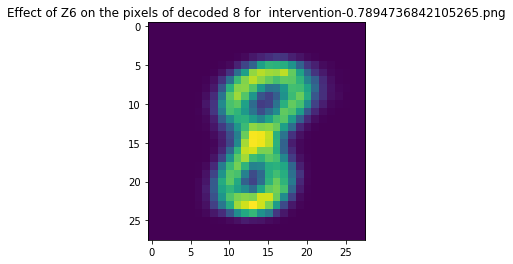

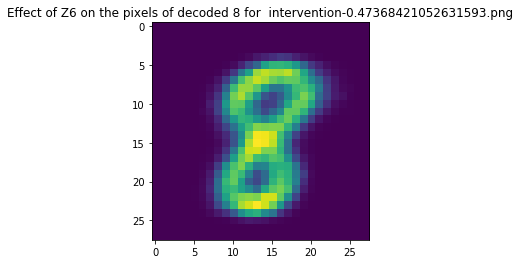

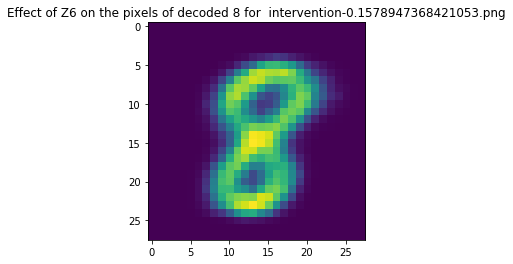

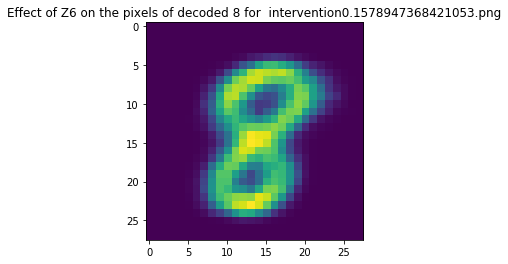

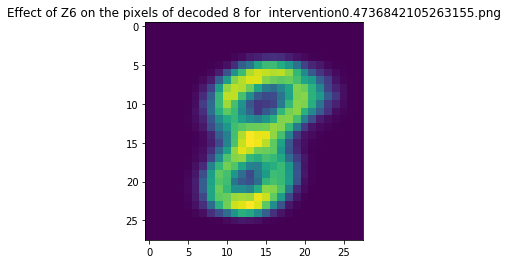

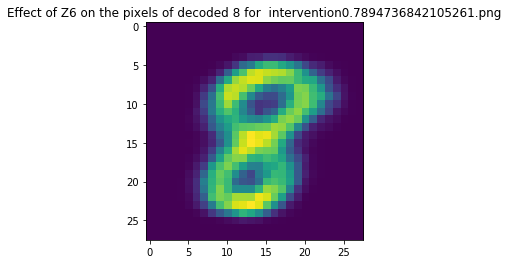

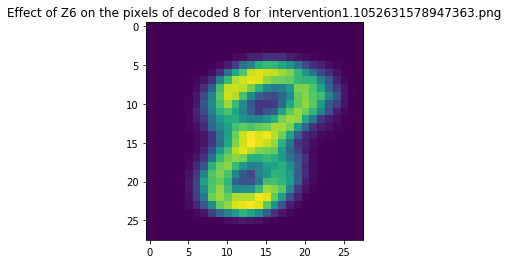

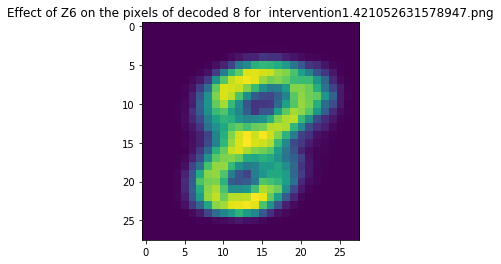

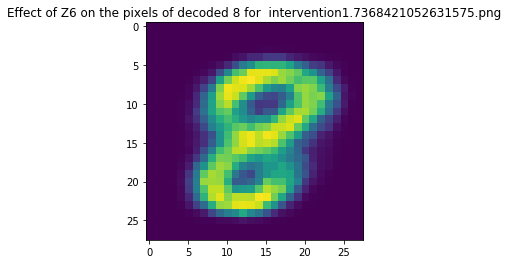

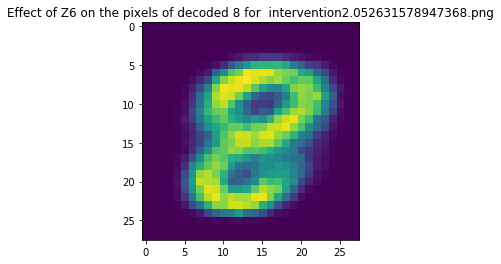

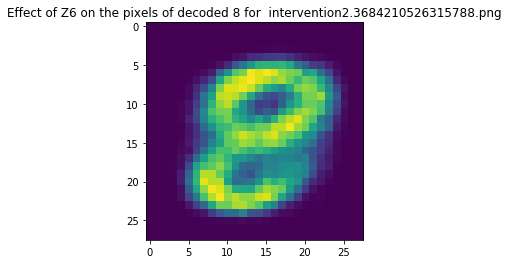

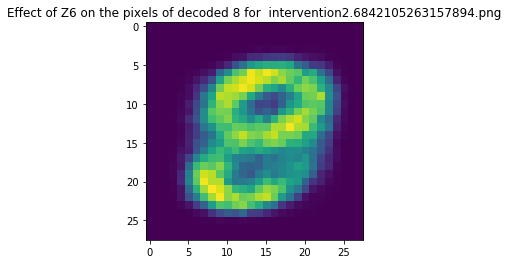

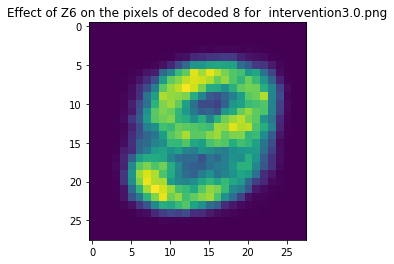

In [0]:
decoder = net.decoder

intervention = np.linspace(-3,3,20)#For traversing this latent & seeing the effect

z=torch.randn(10)#z sampled from std normal distribution
z=torch.cat([z, label])#Input to encoder of c-beta-VAE

for val in intervention:
    z[zl] = val#intervening index zl
    sample = F.sigmoid(decoder(z)).data#sample is conditional probability of the pixel which is same as its conditional expectation since it follows binomial distribution
    sample=sample.view(28,28)
    sample=sample.numpy()
    plt.imshow(sample)
    plt.title("Effect of Z"+str(zl)+" on the pixels of decoded "+str(c)+" for  intervention"+str(val)+".png")
    plt.savefig("Effect of Z"+str(zl)+" on the pixels of decoded "+str(c)+" for  intervention"+str(val)+".png", dpi=1000)
    plt.show()